In [1]:
import numpy as np
import cv2

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

# Task 1

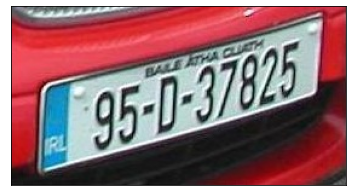

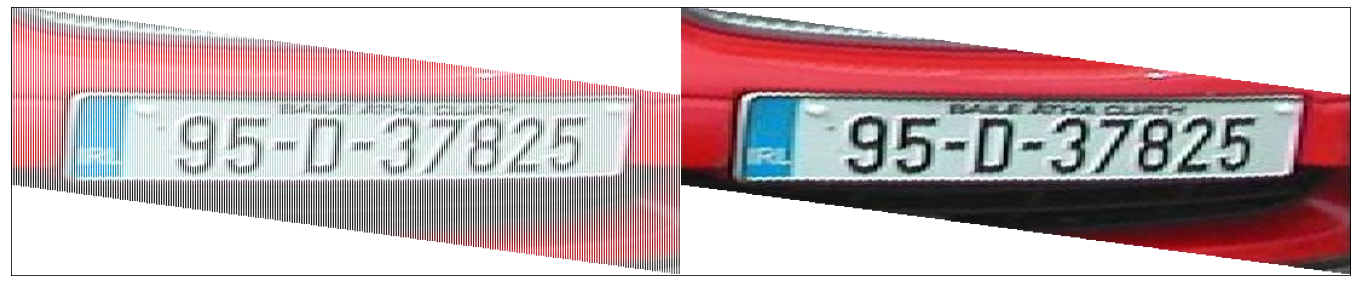

In [2]:
image = cv2.imread('LicensePlate.jpg')

deg = np.deg2rad(15)
height, width, channels = image.shape


def affine_transform(image, transformed_image, T):
    for i, row in enumerate(image):
        for j, col in enumerate(row):
            i_out, j_out, _ = T @ np.array([i, j, 1])
            transformed_image[int(i_out), int(j_out)] = image[i, j]


def nearest_neighbors(image, transformed_image, T_inv):
    for i, row in enumerate(transformed_image):
        for j, col in enumerate(row):
            i_out, j_out, _ = T_inv @ np.array([i, j, 1])
            transformed_image[i, j] = image[round(i_out), round(j_out)]


# Skewing
T_skewing = np.array([
    [1, np.tan(deg), -int( width * np.tan(deg) ) if deg < 0 else 0],
    [0, 1, 0],
    [0, 0, 1],
])
skewing_transformed_image = 255-np.zeros(( int(T_skewing[0,0])*height + int(width * np.abs(np.tan(deg))), int(T_skewing[1,1])*width, 3 ), dtype=np.uint8)
affine_transform(image, skewing_transformed_image, T_skewing)

# Panoramic
T_panoramic = np.array([
    [1, 0, 0],
    [0, 2, 0],
    [0, 0, 1],
])
T_panoramic_inv = np.linalg.inv(T_panoramic)

# Skewing and Panoramic
T = np.array([
    [1, np.tan(deg), -int( width * np.tan(deg) ) if deg < 0 else 0],
    [0, 2, 0],
    [0, 0, 1],
])
skewing_panoramic_transformed_image = 255-np.zeros(( int(T[0,0])*height + int(width * np.abs(np.tan(deg))), int(T[1,1])*width, 3 ), dtype=np.uint8)
affine_transform(image, skewing_panoramic_transformed_image, T)


image_nn = np.empty(skewing_panoramic_transformed_image.shape, dtype=np.uint8)
nearest_neighbors(skewing_transformed_image, image_nn, T_panoramic_inv)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
spt_image = cv2.cvtColor(skewing_panoramic_transformed_image, cv2.COLOR_BGR2RGB)
image_nn = cv2.cvtColor(image_nn, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.xticks([]), plt.yticks([]); plt.show()

figure(figsize=(24, 12))
plt.imshow( np.hstack([ spt_image, image_nn ]) )
plt.xticks([]), plt.yticks([]); plt.show()

# Task 2

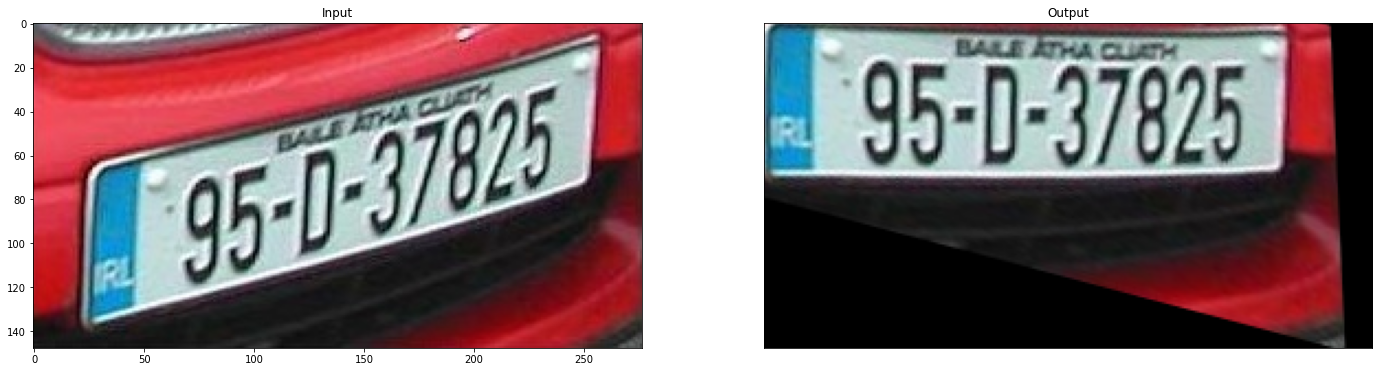

In [3]:
pt_A = [27, 67]
pt_B = [24, 136]
pt_C = [253, 73]
pt_D = [256, 8]

width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C])
output_pts = np.float32([
    [0, 0],
    [0, maxHeight - 1],
    [maxWidth - 1, maxHeight - 1],
])


image = cv2.imread('LicensePlate.jpg')

height, width, channels = image.shape
M = cv2.getAffineTransform(input_pts, output_pts)
dst = cv2.warpAffine(image, M, (width, height))

figure(figsize=(24, 12))
plt.subplot(121),plt.imshow(image[:,:,::-1]),plt.title('Input')
plt.subplot(122),plt.imshow(dst[:,:,::-1]),plt.title('Output')
plt.xticks([]), plt.yticks([]); plt.show()

# Task 3



OpenCV: getPerspectiveTransform


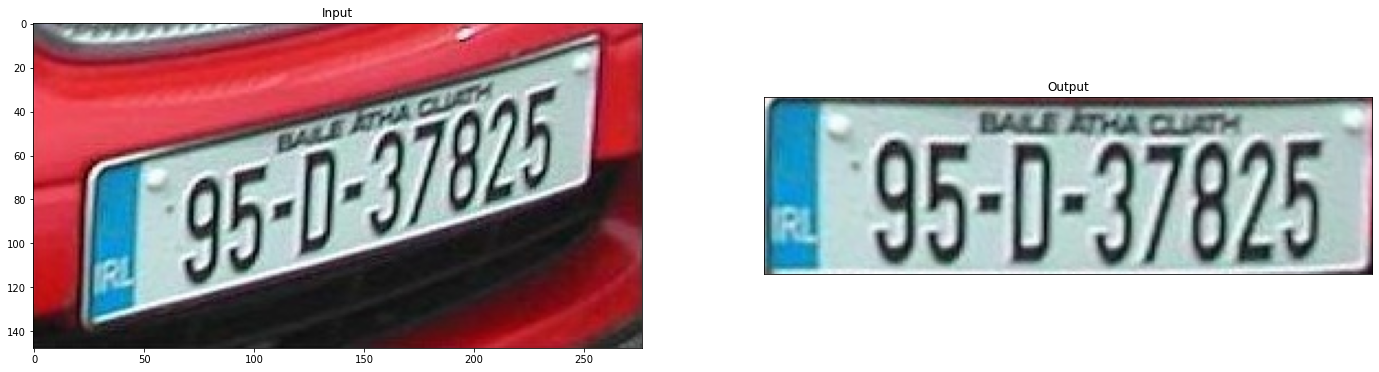

<ipython-input-4-fe3083512d75>:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  A = np.matrix(in_matrix, dtype=np.float)

\My: getPerspectiveTransform


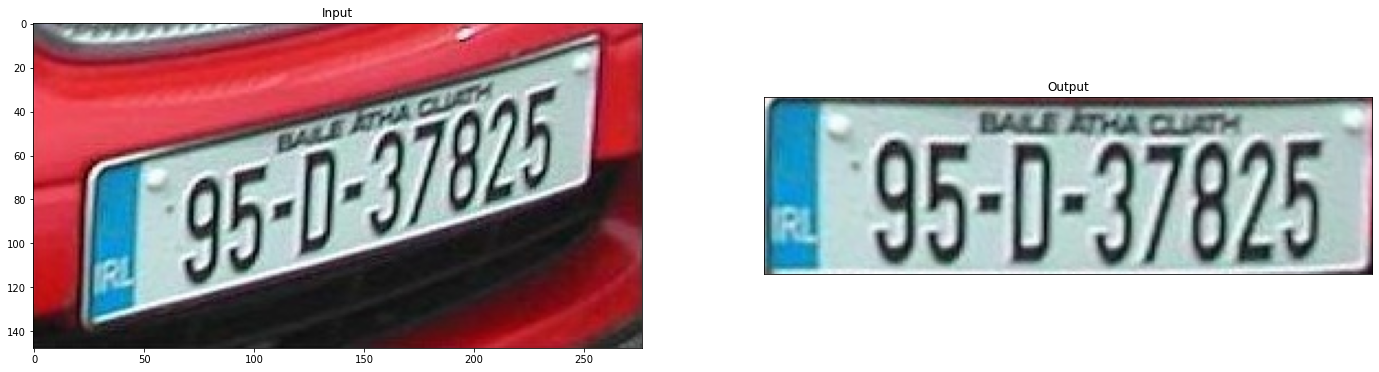

In [4]:
pt_A = [27, 67]
pt_B = [24, 136]
pt_C = [253, 73]
pt_D = [256, 8]

width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))

height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))

input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
output_pts = np.float32([
    [0, 0],
    [0, maxHeight - 1],
    [maxWidth - 1, maxHeight - 1],
    [maxWidth - 1, 0]
])


def create_perspective_transform_matrix(src, dst):
    in_matrix = []
    for (x, y), (X, Y) in zip(src, dst):
        in_matrix.extend([
            [x, y, 1, 0, 0, 0, -X * x, -X * y],
            [0, 0, 0, x, y, 1, -Y * x, -Y * y],
        ])
    A = np.matrix(in_matrix, dtype=np.float)
    B = np.array(dst).reshape(8)
    af = np.dot(np.linalg.inv(A.T * A) * A.T, B)
    return np.append(np.array(af).reshape(8), 1).reshape((3, 3))


image = cv2.imread('LicensePlate.jpg')

M = cv2.getPerspectiveTransform(input_pts, output_pts)
dst = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

print("\n\nOpenCV: getPerspectiveTransform")
figure(figsize=(24, 12))
plt.subplot(121),plt.imshow(image[:,:,::-1]),plt.title('Input')
plt.subplot(122),plt.imshow(dst[:,:,::-1]),plt.title('Output')
plt.xticks([]), plt.yticks([]); plt.show()


M = create_perspective_transform_matrix(input_pts, output_pts)
dst = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

print("\n\My: getPerspectiveTransform")
figure(figsize=(24, 12))
plt.subplot(121),plt.imshow(image[:,:,::-1]),plt.title('Input')
plt.subplot(122),plt.imshow(dst[:,:,::-1]),plt.title('Output')
plt.xticks([]), plt.yticks([]); plt.show()

# Task 4

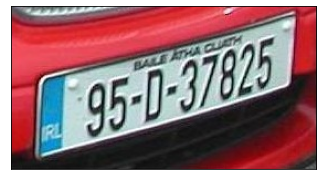

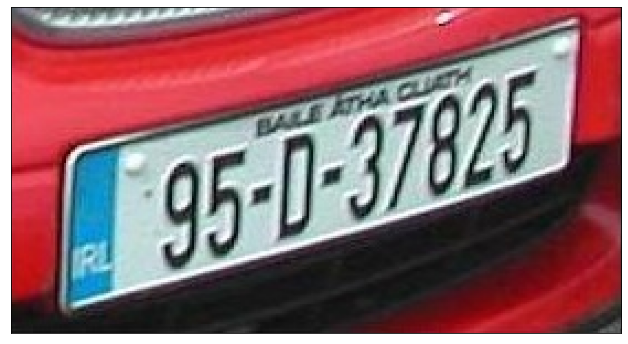

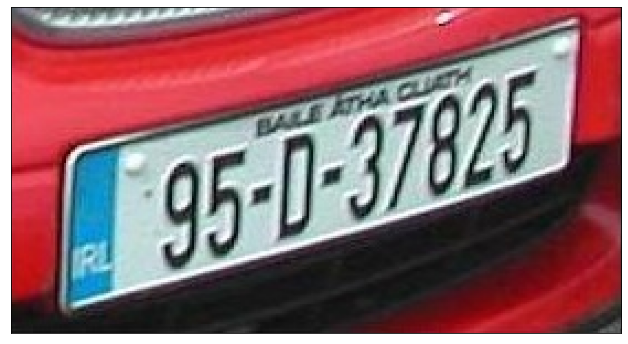

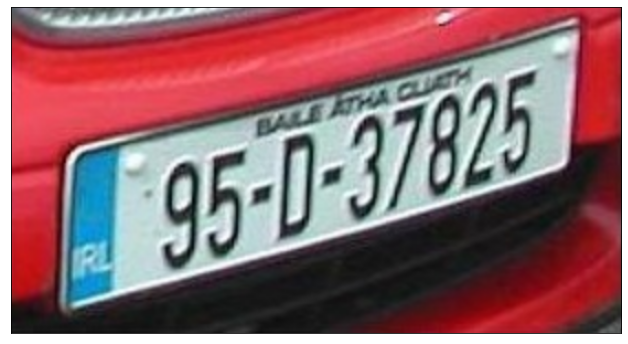

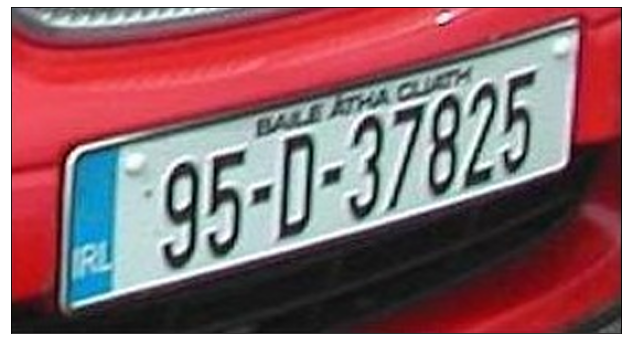

In [5]:
image = cv2.imread('LicensePlate.jpg')
height, width, channels = image.shape


def affine_transform(image, transformed_image, T):
    for i, row in enumerate(image):
        for j, col in enumerate(row):
            i_out, j_out, _ = T @ np.array([i, j, 1])
            transformed_image[int(i_out), int(j_out)] = image[i, j]


def nearest_neighbors(image, image_nn, T_inv):
    for i, row in enumerate(image_nn):
        for j, col in enumerate(row):
            i_out, j_out, _ = T_inv @ np.array([i, j, 1])
            image_nn[i, j] = image[int(i_out), int(j_out)]


T_scale = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1],
])
T_scale_inv = np.linalg.inv(T_scale)
image_nn = np.empty(( int(T_scale[0,0])*height, int(T_scale[1,1])*width, 3 ), dtype=np.uint8)
nearest_neighbors(image, image_nn, T_scale_inv)


near_img = cv2.resize(image,None, fx = 2, fy = 2, interpolation = cv2.INTER_NEAREST)
bilinear_img = cv2.resize(image,None, fx = 2, fy = 2, interpolation = cv2.INTER_LINEAR)
bicubic_img = cv2.resize(image,None, fx = 2, fy = 2, interpolation = cv2.INTER_CUBIC)


figure(figsize=(6, 3))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]); plt.show()

figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(image_nn, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]); plt.show()

figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(near_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]); plt.show()

figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(bilinear_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]); plt.show()

figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(bicubic_img, cv2.COLOR_BGR2RGB))
plt.xticks([]), plt.yticks([]); plt.show()